In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#from multi_run.backtest_v3 import simulate_longonly, simulate_longshort
from multi_run.backtest_daily import simulate_longonly_d, simulate_longshort_d
from multi_run.initialize_v2 import data_pp
from multi_run.momentum_strategy_v3 import weekly_momentum_value_weighted

2023-05-17 10:08:22,285	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-17 10:08:26,049	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [2]:
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
cmkt_data = data_pp(cmktcap, vender="coinmarketcap")

#binance = pd.read_pickle("Data/binance_data_pp.pickle")
#cmkt_data = data_pp(binance, vender="binance")

In [3]:
daily_rtn = cmkt_data["price"].pct_change(fill_method=None)

In [ ]:
inner = weekly_momentum_value_weighted(price_df=cmkt_data["price"],
                                        mktcap_df=cmkt_data["mktcap"],
                                        vol_df=cmkt_data["vol"], 
                                        n_group=5,
                                        day_of_week="SUN",
                                        number_of_coin_group=20, 
                                        mktcap_thresh=1_000_000,
                                        vol_thresh=1_000_000,
                                        freq="Daily")
# daily_rtn_df, mktcap_used, group_mask_dict

In [67]:
def simulate_longshort_d(long_weight_df:pd.DataFrame, short_weight_df:pd.DataFrame, price_df:pd.DataFrame, fee_rate:float, margin:str):
    '''가격 기반으로, MTS 시스템과 일치하게 동작하도록 수정한다
    
       공매도하고 Cash를 받고, 받은만큼 주식을 산다
    '''
    # Setting the Initial values 
    cash = 0
    asset_value = 0
    pf_value = cash + asset_value
      
    # 첫 일주일(최초 1/7씩 진입)
    for date in long_weight_df.index[:6]:
        today_price = price_df.loc[date]
        today_short_weight = short_weight_df.loc[date]
        today_long_weight  = long_weight_df.loc[date]
        
        # 오늘 코인을 몇 개 사야하는 지 구한다 (매일 1/7씩 진입)
        short_coin_num = -(today_short_weight * (1/7)  / today_price)  # Short 개수는 음수로 기록
        long_coin_num  =  (today_long_weight  * (1/7) / today_price)
        
        # 공매도하고, 그만큼 현금을 받는다 (Price는 지불해야하는 가격이니, 거기에 마이너스를 붙이면 숏을 했을 때 수취하는 현금이 된다)
        asset_value_array_short = short_coin_num * (-today_price)
        cash += np.nansum(asset_value_array_short)
        asset_value_array_long = long_coin_num * today_price # 수취한 현금만큼 Long을 한다 
        cash -= np.nansum(asset_value_array_long) # 코인을 구입 했기 때문에 현금을 차감한다
        
        asset_value = np.nansum(asset_value_array_short) + np.nansum(asset_value_array_long)
        print(date,cash)
        print("Asset", asset_value)

In [68]:
a = simulate_longshort_d(inner[4], 
                         inner[0],         
                    daily_rtn,
                    0.0015,
                    "isolate")

2017-12-02 00:00:00 -2.7755575615628914e-17
Asset 0.2857142857142857
2017-12-03 00:00:00 -2.7755575615628914e-17
Asset 0.2857142857142857
2017-12-04 00:00:00 -5.551115123125783e-17
Asset 0.2857142857142857
2017-12-05 00:00:00 -5.551115123125783e-17
Asset 0.2857142857142857
2017-12-06 00:00:00 -8.326672684688674e-17
Asset 0.2857142857142857
2017-12-07 00:00:00 -1.1102230246251565e-16
Asset 0.2857142857142857


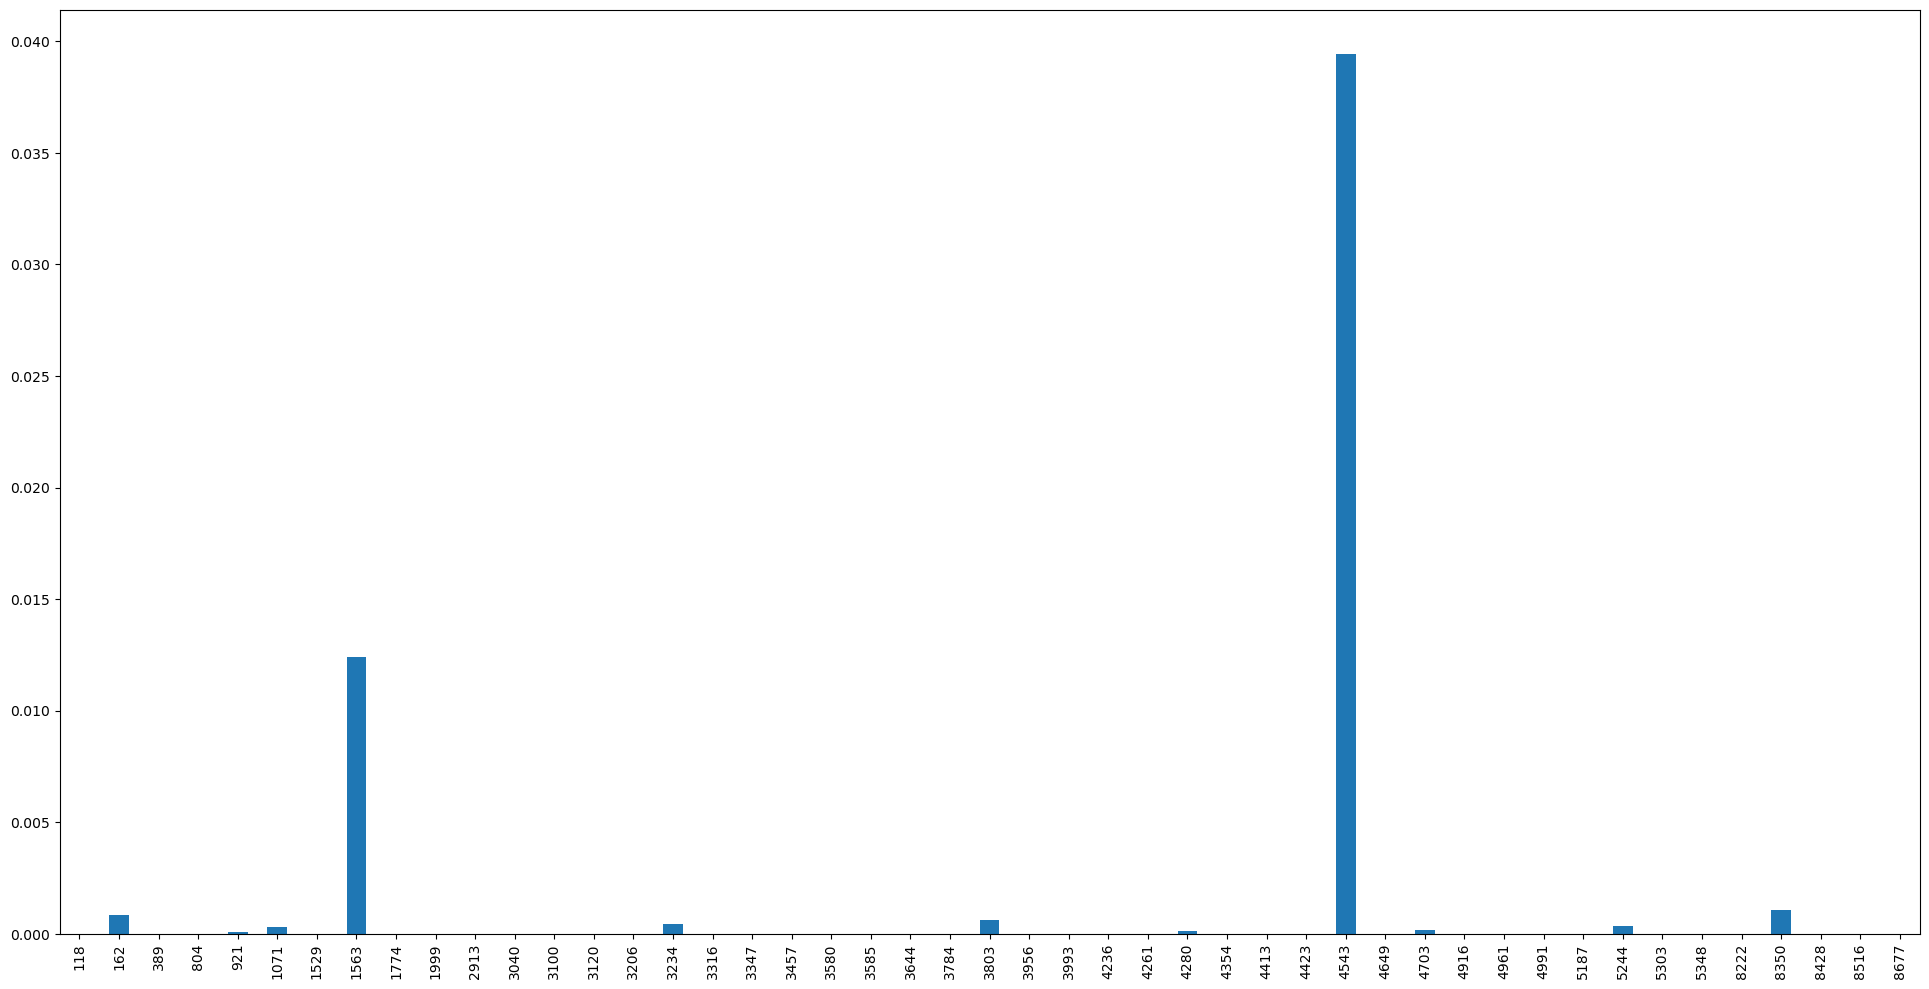

In [33]:
sample = pd.Series(a[0])
sample2 = pd.Series(a[1])
#sample2.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12))
sample.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12), subplots=True);

<AxesSubplot:>

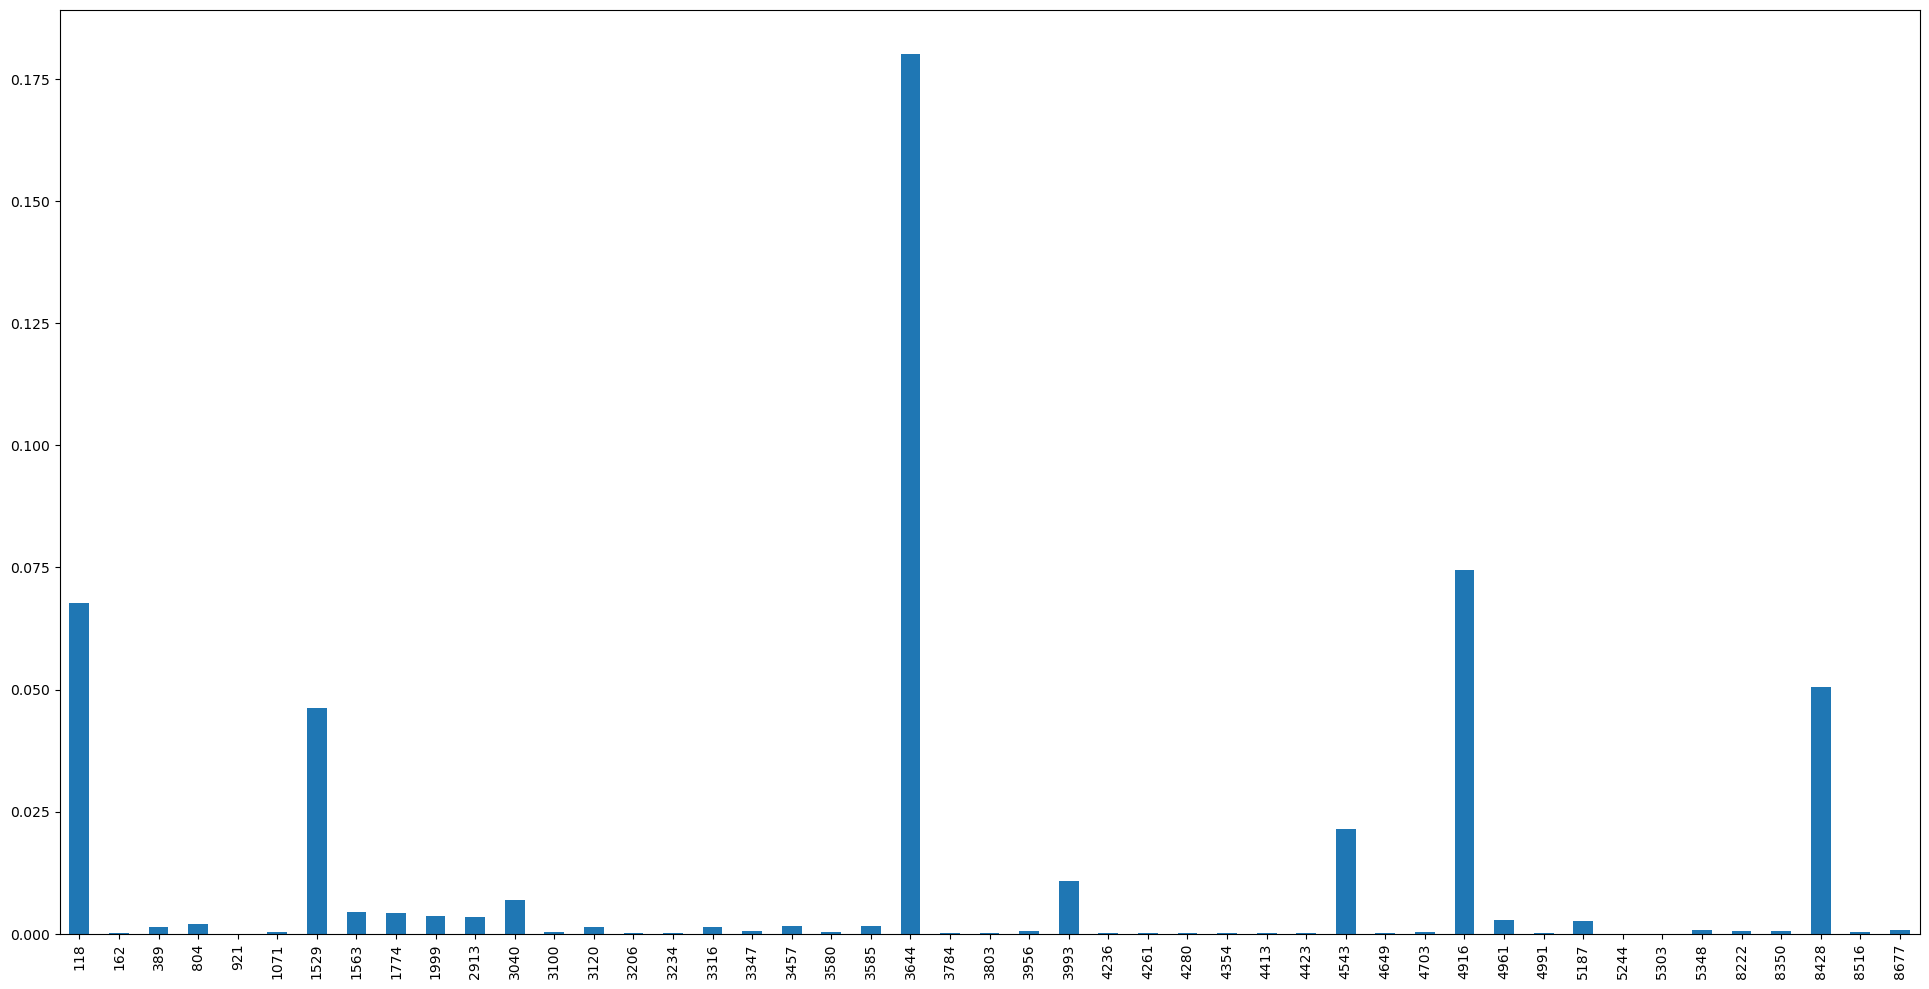

In [34]:
sample2.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12))

In [47]:
# 위치를 학인해야한다

bol1 = (a[0] != 0)
bol2 = (a[1] != 0)

In [61]:
np.sum(bol1) + np.sum(bol2)

93

In [64]:
np.sum(bol1 + bol2)

82

In [49]:
bol1

array([ True, False, False, ..., False, False, False])

In [17]:
np.nansum(a[0]) #+ np.nansum(a[1])

0.6427678190511318

<AxesSubplot:>

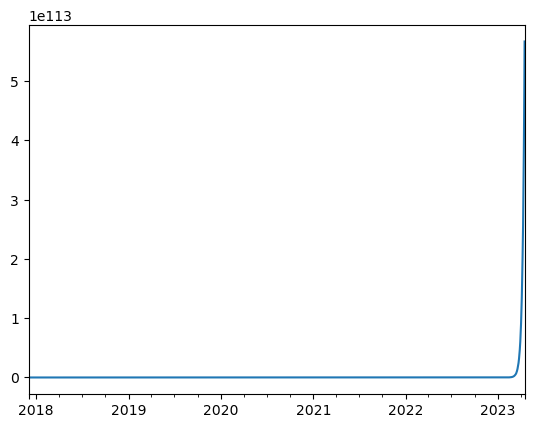

In [74]:
pd.Series(a).plot()

<AxesSubplot:>

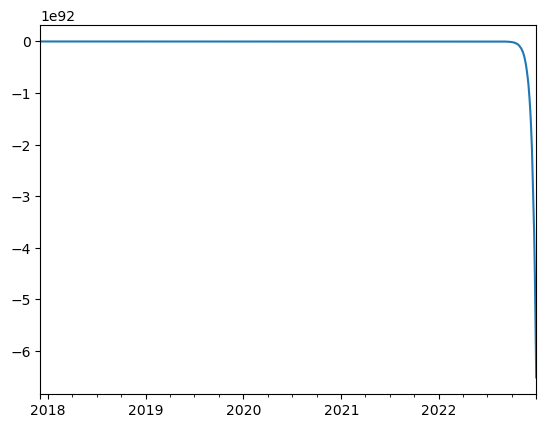

In [55]:
pd.Series(a).loc[:"2022"].plot()

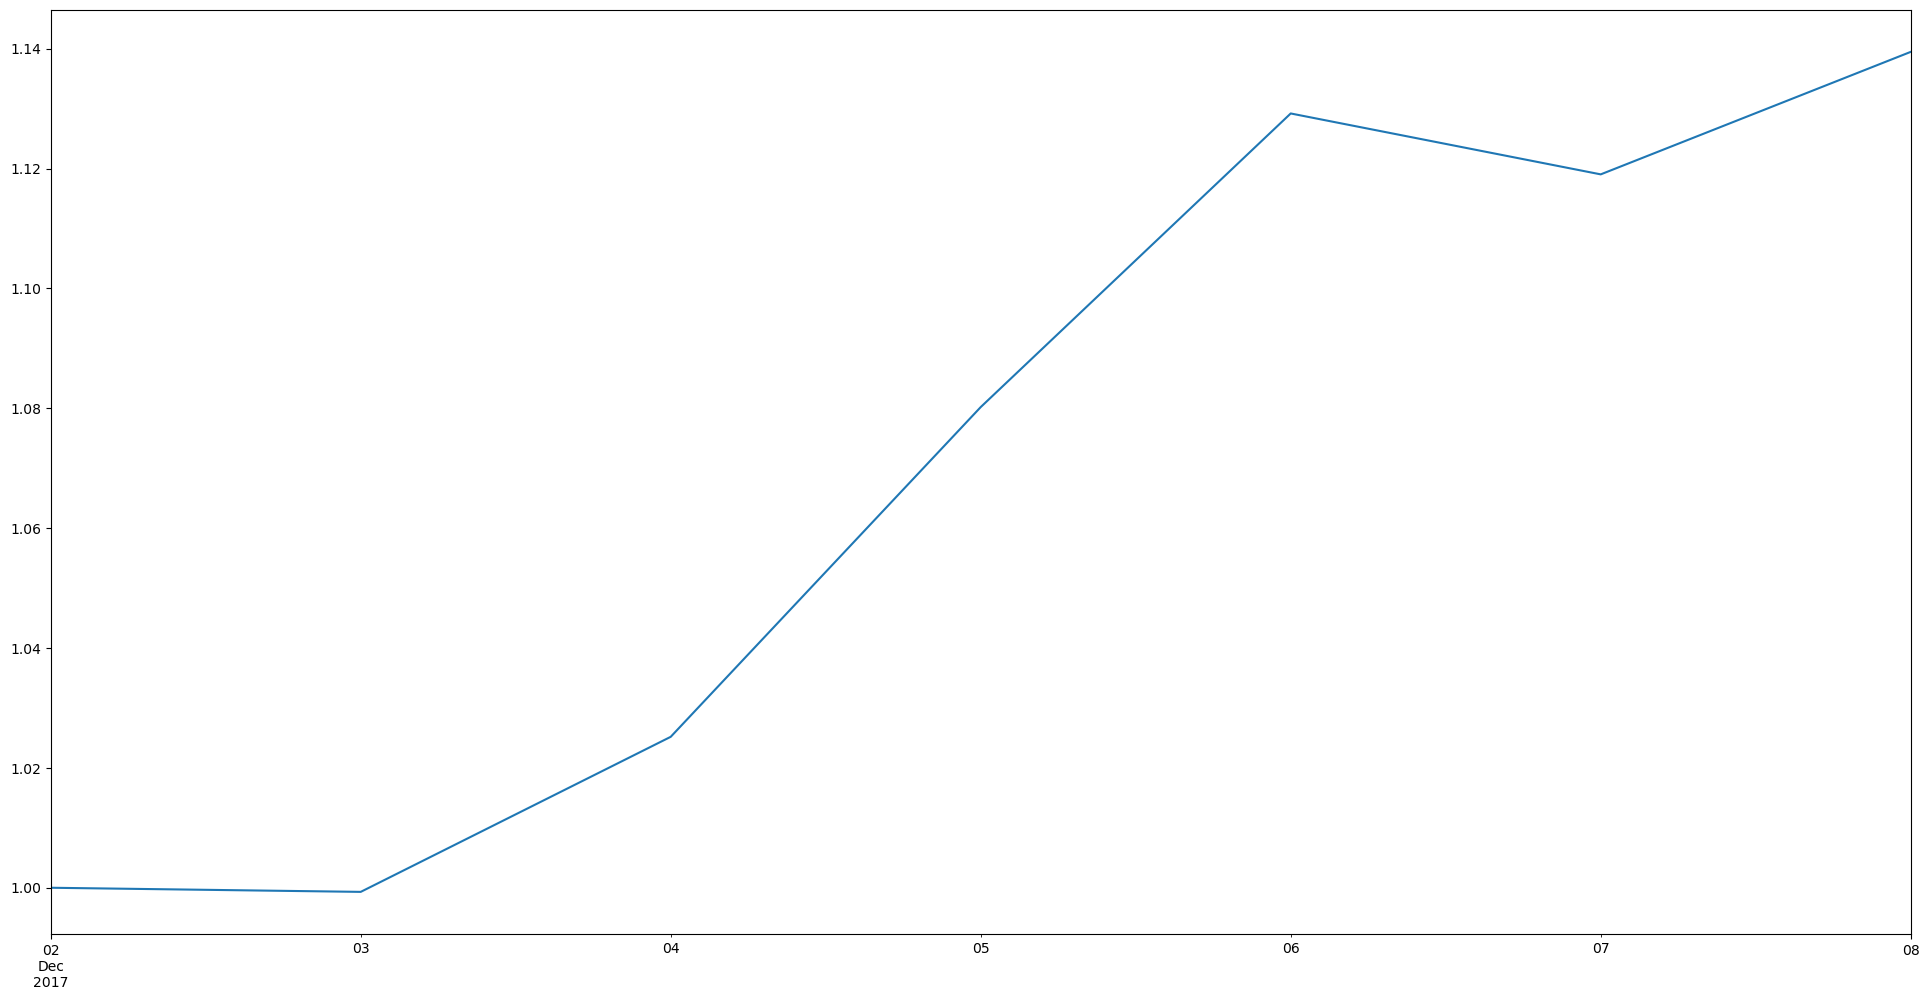

In [43]:
pd.Series(a).iloc[:7].plot(figsize=(24,12));

<AxesSubplot:>

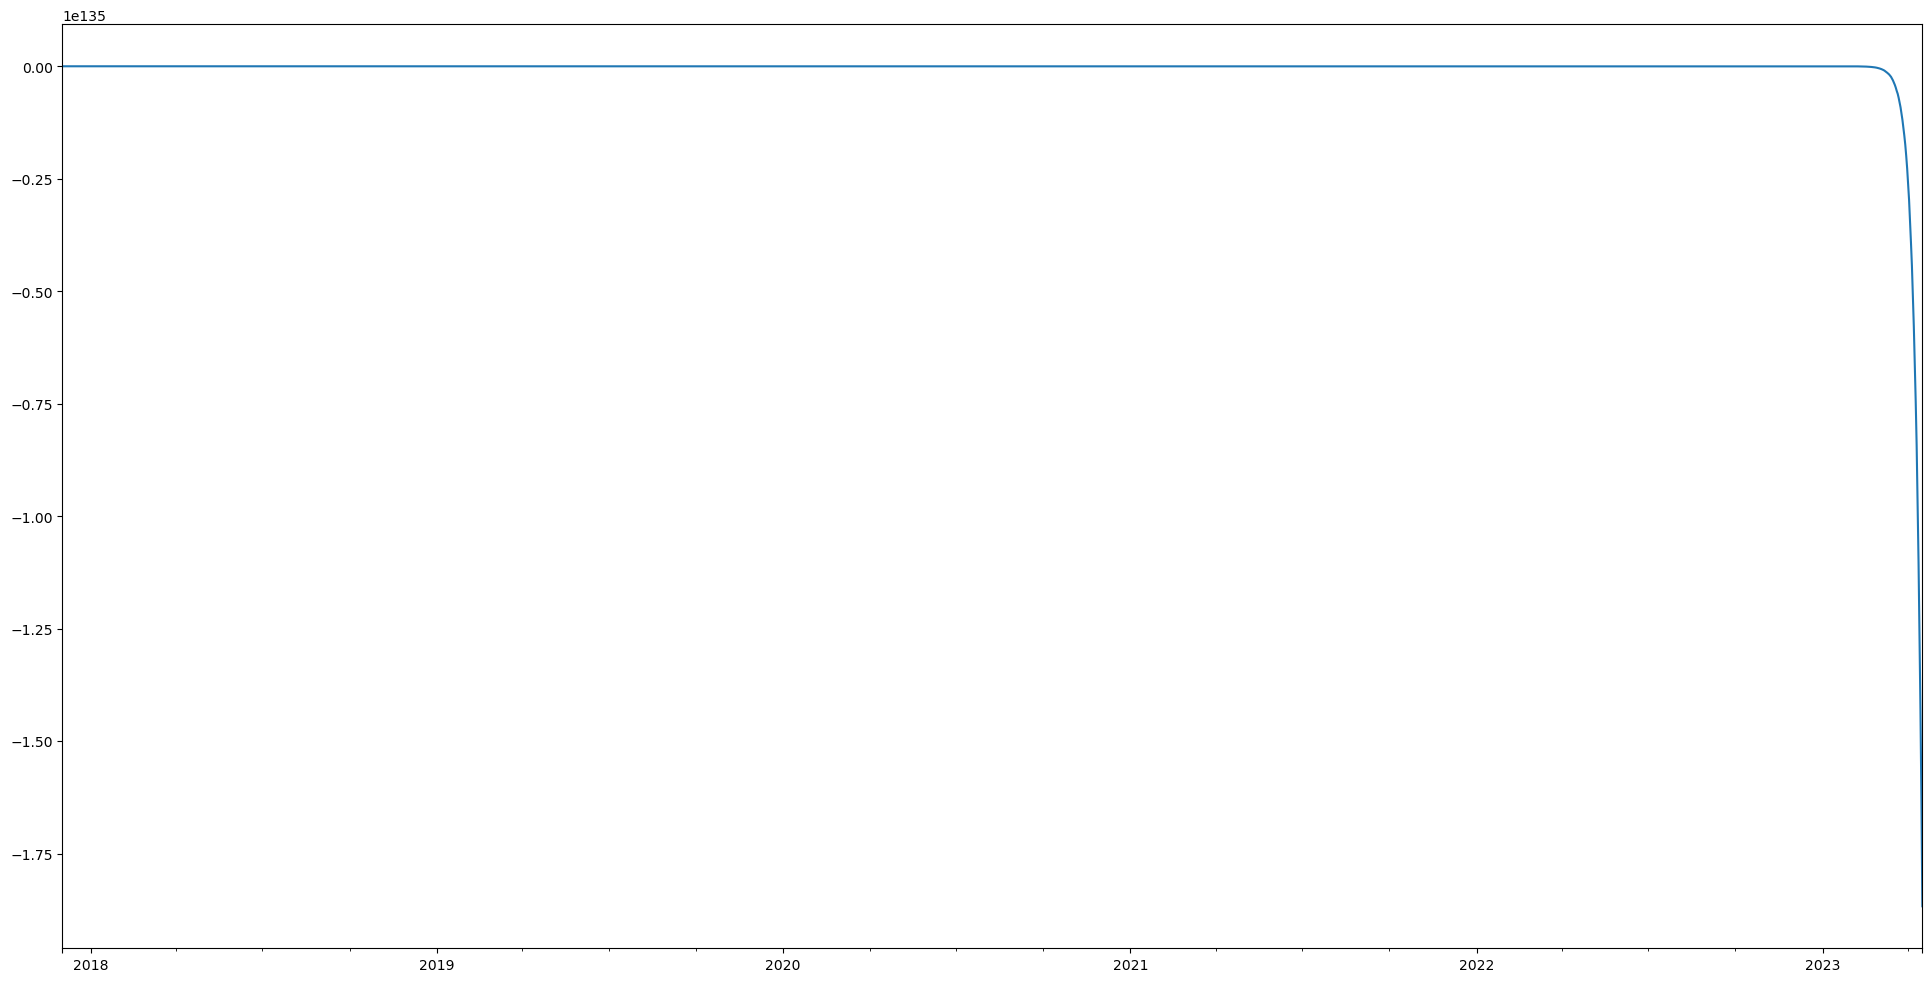

In [38]:
pd.Series(a).plot(figsize=(24,12))#.plot(figsize=(24,12));